In [70]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GroupKFold

In [ ]:
image_size = (256, 266)
batch_size = 32
epochs = 50

In [72]:
def load_data(images_path, labels_path):
    X, y, groups = [], [], []
    labels_set = set()
    for label_file in os.listdir(labels_path):
        if label_file.endswith('.txt'):
            label_path = os.path.join(labels_path, label_file)
            folder_num = label_file.split('.')[0]
            image_folder = os.path.join(images_path, folder_num)
            if os.path.exists(image_folder):
                with open(label_path, 'r') as f:
                    labels = f.read().strip().split(',')
                    labels_set.update(labels)
                    for image_file in os.listdir(image_folder):
                        if image_file.endswith('.png'):
                            image_path = os.path.join(image_folder, image_file)
                            image = load_img(image_path, target_size=image_size)
                            image = img_to_array(image) / 255.0
                            X.append(image)
                            y.append(labels)
                            groups.append(folder_num)

    label_to_index = {label: index for index, label in enumerate(labels_set)}
    y_encoded = np.zeros((len(y), len(label_to_index)))
    for i, labels in enumerate(y):
        for label in labels:
            y_encoded[i, label_to_index[label]] = 1

    X = np.array(X)
    y_encoded = np.array(y_encoded)
    groups = np.array(groups)

    return X, y_encoded, groups, label_to_index

In [73]:
images_path = 'images'
labels_path = 'labels'

X, y, groups, label_to_index = load_data(images_path, labels_path)

In [74]:
group_kfold = GroupKFold(n_splits=5)
train_idx, test_idx = next(group_kfold.split(X, y, groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [75]:
# print example of data
print('X shape:', X.shape)
print('y shape:', y.shape)
print('label_to_index:', label_to_index)

X shape: (275, 256, 266, 3)
y shape: (275, 54)
label_to_index: {'couch': 0, 'wine glass': 1, 'potted plant': 2, 'stairs': 3, 'bench': 4, 'wall-brick': 5, 'fence-merged': 6, 'rug-merged': 7, 'umbrella': 8, 'cup': 9, 'pavement-merged': 10, 'door-stuff': 11, 'handbag': 12, 'tree-merged': 13, 'rock-merged': 14, 'skateboard': 15, 'mountain-merged': 16, 'bowl': 17, 'tent': 18, 'light': 19, 'table-merged': 20, 'sea': 21, 'floor-other-merged': 22, 'spoon': 23, 'shelf': 24, 'flower': 25, 'house': 26, 'roof': 27, 'person': 28, 'laptop': 29, 'sky-other-merged': 30, 'vase': 31, 'dining table': 32, 'curtain': 33, 'apple': 34, 'cabinet-merged': 35, 'towel': 36, 'gravel': 37, 'wall-wood': 38, 'building-other-merged': 39, 'donut': 40, 'bed': 41, 'knife': 42, 'floor-wood': 43, 'water-other': 44, 'window-other': 45, 'book': 46, 'orange': 47, 'wall-stone': 48, 'ceiling-merged': 49, 'grass-merged': 50, 'chair': 51, 'bottle': 52, 'wall-other-merged': 53}


In [85]:
model = Sequential([
    Conv2D(256, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3), padding='same', strides=1),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same', strides=1),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same', strides=1),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_to_index), activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\Bod\PycharmProjects\scene-gen-ai\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [87]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[early_stopping])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.0905 - loss: 0.6063 - val_accuracy: 0.0364 - val_loss: 0.5480
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.0520 - loss: 0.5624 - val_accuracy: 0.0364 - val_loss: 0.4888
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.0687 - loss: 0.5305 - val_accuracy: 0.0364 - val_loss: 0.4392
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.0947 - loss: 0.5058 - val_accuracy: 0.0364 - val_loss: 0.4511
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.1303 - loss: 0.4717 - val_accuracy: 0.0364 - val_loss: 0.4123
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.1923 - loss: 0.4475 - val_accuracy: 0.0364 - val_loss: 0.4023
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.1641 - loss: 0.4308 - val_accuracy: 0.0364 - val_loss: 0.3775
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.2027 - loss: 0.4118 - val_accuracy: 0.0364 - val_loss: 0.3875
Epoch 9/

In [84]:
model.save('background_label_predictor.h5')

In [88]:
# show example of image, predicted labels and true labels
import matplotlib.pyplot as plt

def show_example(X, y, label_to_index, index_to_label, index):
    image = X[index]
    labels = y[index]
    predicted_labels = model.predict(np.array([image]))[0]
    predicted_labels = [index_to_label[i] for i, value in enumerate(predicted_labels) if value > 0.5]
    labels = [index_to_label[i] for i, value in enumerate(labels) if value > 0.5]

    plt.imshow(image)
    plt.title('Predicted labels: ' + ', '.join(predicted_labels) + '\nTrue labels: ' + ', '.join(labels))
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


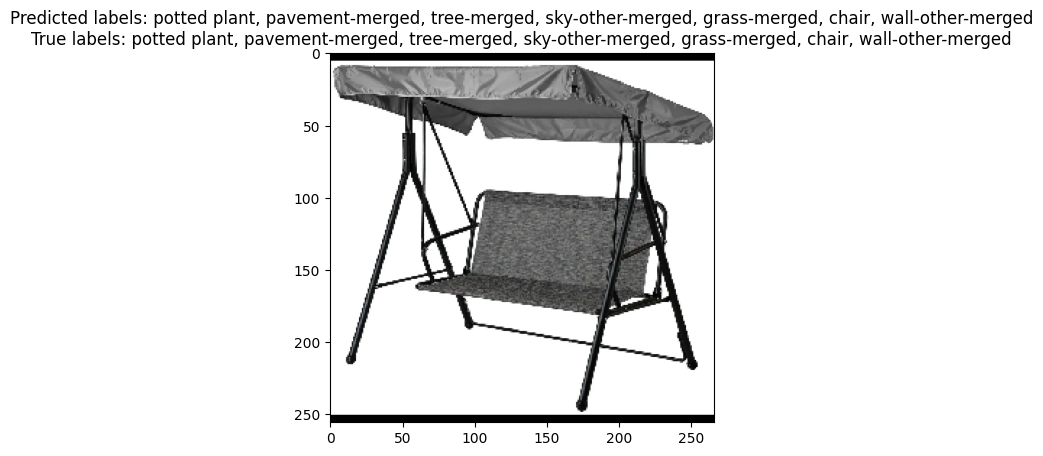

In [89]:
show_example(X_test, y_test, label_to_index, {index: label for label, index in label_to_index.items()}, 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


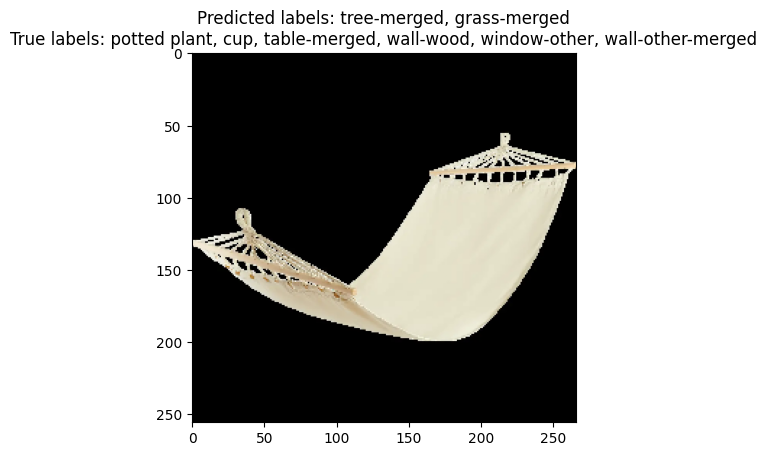

In [90]:
show_example(X_test, y_test, label_to_index, {index: label for label, index in label_to_index.items()}, 10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


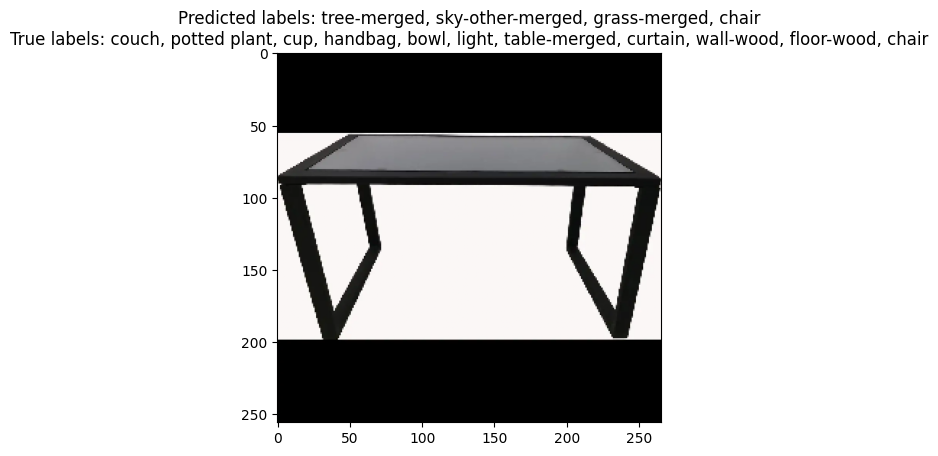

In [91]:
show_example(X_test, y_test, label_to_index, {index: label for label, index in label_to_index.items()}, 20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


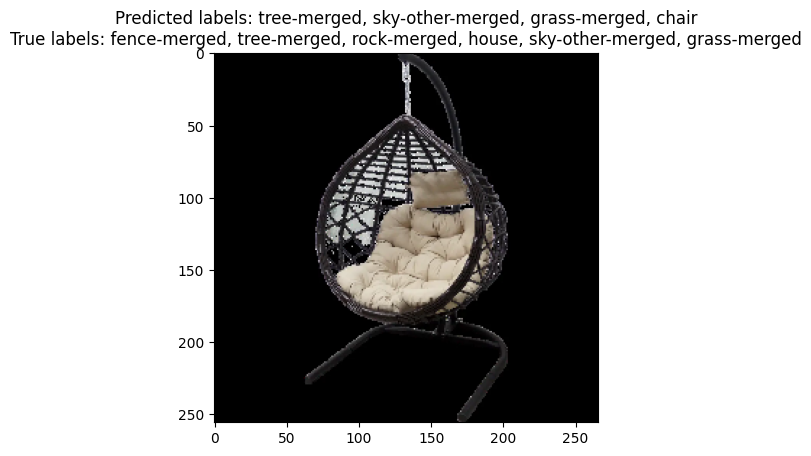

In [92]:
show_example(X_test, y_test, label_to_index, {index: label for label, index in label_to_index.items()}, 30)

In [93]:
# load "image_test.png" and predict labels
image = load_img('image_test.png', target_size=image_size)
image = img_to_array(image) / 255.0
predicted_labels = model.predict(np.array([image]))[0]
predicted_labels = [index for index, value in enumerate(predicted_labels) if value > 0.5]
predicted_labels = [label for label, index in label_to_index.items() if index in predicted_labels]
print('Predicted labels:', predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted labels: ['tree-merged', 'sky-other-merged', 'grass-merged', 'chair']
